In [ ]:
import pandas as pd



train = pd.read_parquet('train.parquet')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

In [4]:
train.describe()



bid_qty        ask_qty        buy_qty       sell_qty  \
count  525887.000000  525887.000000  525887.000000  525887.000000   
mean        9.968003      10.174169     131.726678     132.673944   
std        15.645741      15.889582     307.267251     309.803040   
min         0.001000       0.001000       0.000000       0.000000   
25%         2.634000       2.678000      26.407000      27.021000   
50%         6.415000       6.538000      57.015000      58.047000   
75%        13.085000      13.330000     127.639000     129.110000   
max      1114.932000    1352.965000   17614.400000   17686.234000   

              volume             X1             X2             X3  \
count  525887.000000  525887.000000  525887.000000  525887.000000   
mean      264.400622      -0.006026      -0.000243      -0.000353   
std       588.618746       0.538340       0.613746       0.771744   
min         0.000000      -2.787539      -5.861926      -6.125439   
25%        60.688500      -0.370635      -0.314135      -0.441536   
50%       120.799000      -0.015991      -0.001713      -0.003010   
75%       256.733500       0.349104       0.310181       0.431960   
max     28701.419000       2.972741       6.151366       6.488532   

                  X4             X5  ...           X882           X883  \
count  525887.000000  525887.000000  ...  525887.000000  525887.000000   
mean       -0.000425      -0.000263  ...       1.959330       1.954978   
std         0.857115       0.464695  ...       0.844732       0.598279   
min        -6.093792      -2.855040  ...       0.433416       0.686524   
25%        -0.521693      -0.295502  ...       1.367222       1.521202   
50%        -0.003948      -0.002545  ...       1.831805       1.882957   
75%         0.507830       0.287728  ...       2.369648       2.274296   
max         6.394355       3.184776  ...       6.881902       4.745380   

                X884           X885           X886           X887  \
count  525887.000000  525887.000000  525887.000000  525887.000000   
mean        0.498112       0.498063       0.497997       0.497872   
std         0.712811       0.698678       0.684946       0.666936   
min         0.000004       0.000006       0.000009       0.000024   
25%         0.000162       0.000193       0.000241       0.000997   
50%         0.000634       0.001036       0.004593       0.039178   
75%         1.473225       1.472025       1.442417       1.380184   
max         1.584315       1.584315       1.584315       1.584315   

                X888           X889           X890          label  
count  525887.000000  525887.000000  525887.000000  525887.000000  
mean        0.497525       0.497372       0.995394       0.036126  
std         0.615440       0.546439       0.850509       1.009914  
min         0.003903       0.015654       0.092913     -24.416615  
25%         0.033156       0.066908       0.244373      -0.381585  
50%         0.127865       0.161757       0.634448       0.016262  
75%         1.120480       0.999344       1.701838       0.434135  
max         1.583862       1.557910       2.769604      20.740270  

[8 rows x 896 columns]

In [18]:
anonymized_features = list(train.columns[list(range(5, train.shape[1] - 1))])
target = 'label'

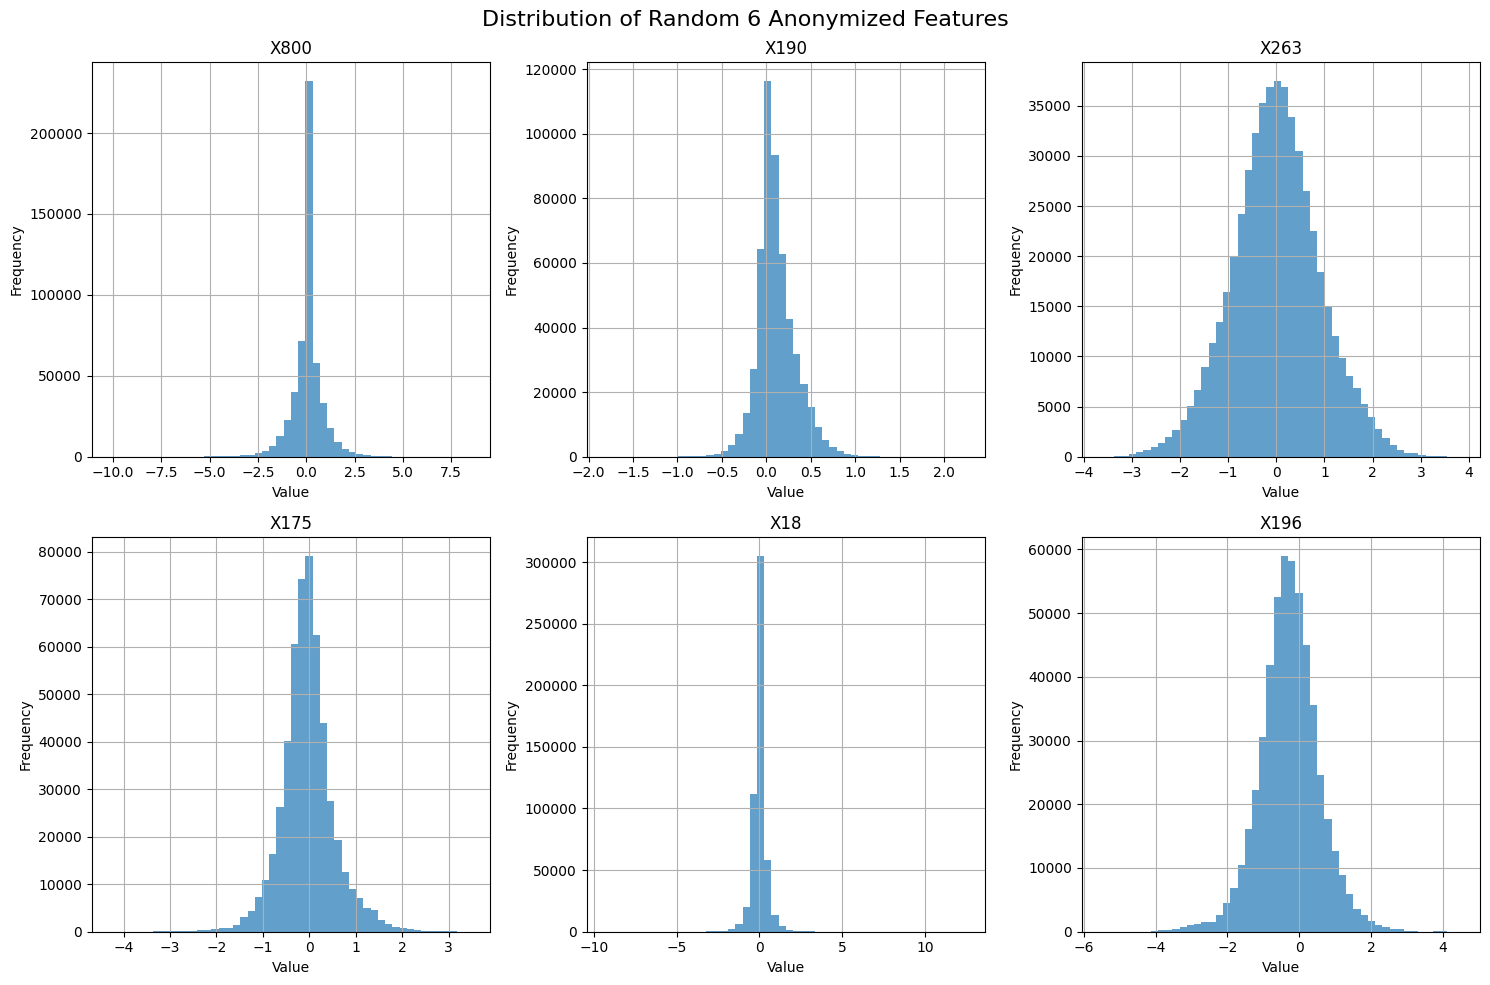

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Random 6 Anonymized Features', fontsize=16)


import random
for i, feature in enumerate(random.sample(list(anonymized_features), 6)):
    row, col = i // 3, i % 3
    train[feature].hist(bins=50, ax=axes[row, col], alpha=0.7)
    axes[row, col].set_title(f'{feature}')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [6]:
(train.isna().sum() / train.shape[0] * 100).sort_values().round(2)

bid_qty     0.0
ask_qty     0.0
buy_qty     0.0
sell_qty    0.0
volume      0.0
           ... 
X887        0.0
X888        0.0
X889        0.0
X890        0.0
label       0.0
Length: 896, dtype: float64

In [7]:
train.head()

bid_qty  ask_qty  buy_qty  sell_qty   volume        X1  \
timestamp                                                                     
2023-03-01 00:00:00   15.283    8.425  176.405    44.984  221.389  0.121263   
2023-03-01 00:01:00   38.590    2.336  525.846   321.950  847.796  0.302841   
2023-03-01 00:02:00    0.442   60.250  159.227   136.369  295.596  0.167462   
2023-03-01 00:03:00    4.865   21.016  335.742   124.963  460.705  0.072944   
2023-03-01 00:04:00   27.158    3.451   98.411    44.407  142.818  0.173820   

                           X2        X3        X4        X5  ...      X882  \
timestamp                                                    ...             
2023-03-01 00:00:00 -0.417690  0.005399  0.125948  0.058359  ...  1.925423   
2023-03-01 00:01:00 -0.049576  0.356667  0.481087  0.237954  ...  1.928569   
2023-03-01 00:02:00 -0.291212  0.083138  0.206881  0.101727  ...  1.928047   
2023-03-01 00:03:00 -0.436590 -0.102483  0.017551  0.007149  ...  1.928621   
2023-03-01 00:04:00 -0.213489  0.096067  0.215709  0.107133  ...  1.927084   

                         X883      X884      X885      X886      X887  \
timestamp                                                               
2023-03-01 00:00:00  1.847943  0.005676  0.190791  0.369691  0.377630   
2023-03-01 00:01:00  1.849468  0.005227  0.184660  0.363642  0.374515   
2023-03-01 00:02:00  1.849282  0.004796  0.178719  0.357689  0.371424   
2023-03-01 00:03:00  1.849608  0.004398  0.172967  0.351832  0.368358   
2023-03-01 00:04:00  1.848950  0.004008  0.167391  0.346066  0.365314   

                         X888      X889      X890     label  
timestamp                                                    
2023-03-01 00:00:00  0.210153  0.159183  0.530636  0.562539  
2023-03-01 00:01:00  0.209573  0.158963  0.530269  0.533686  
2023-03-01 00:02:00  0.208993  0.158744  0.529901  0.546505  
2023-03-01 00:03:00  0.208416  0.158524  0.529534  0.357703  
2023-03-01 00:04:00  0.207839  0.158304  0.529167  0.362452  

[5 rows x 896 columns]

In [8]:
print(train.index[0], train.index[-1])

2023-03-01 00:00:00 2024-02-29 23:59:00


In [9]:
train.shape

(525887, 896)

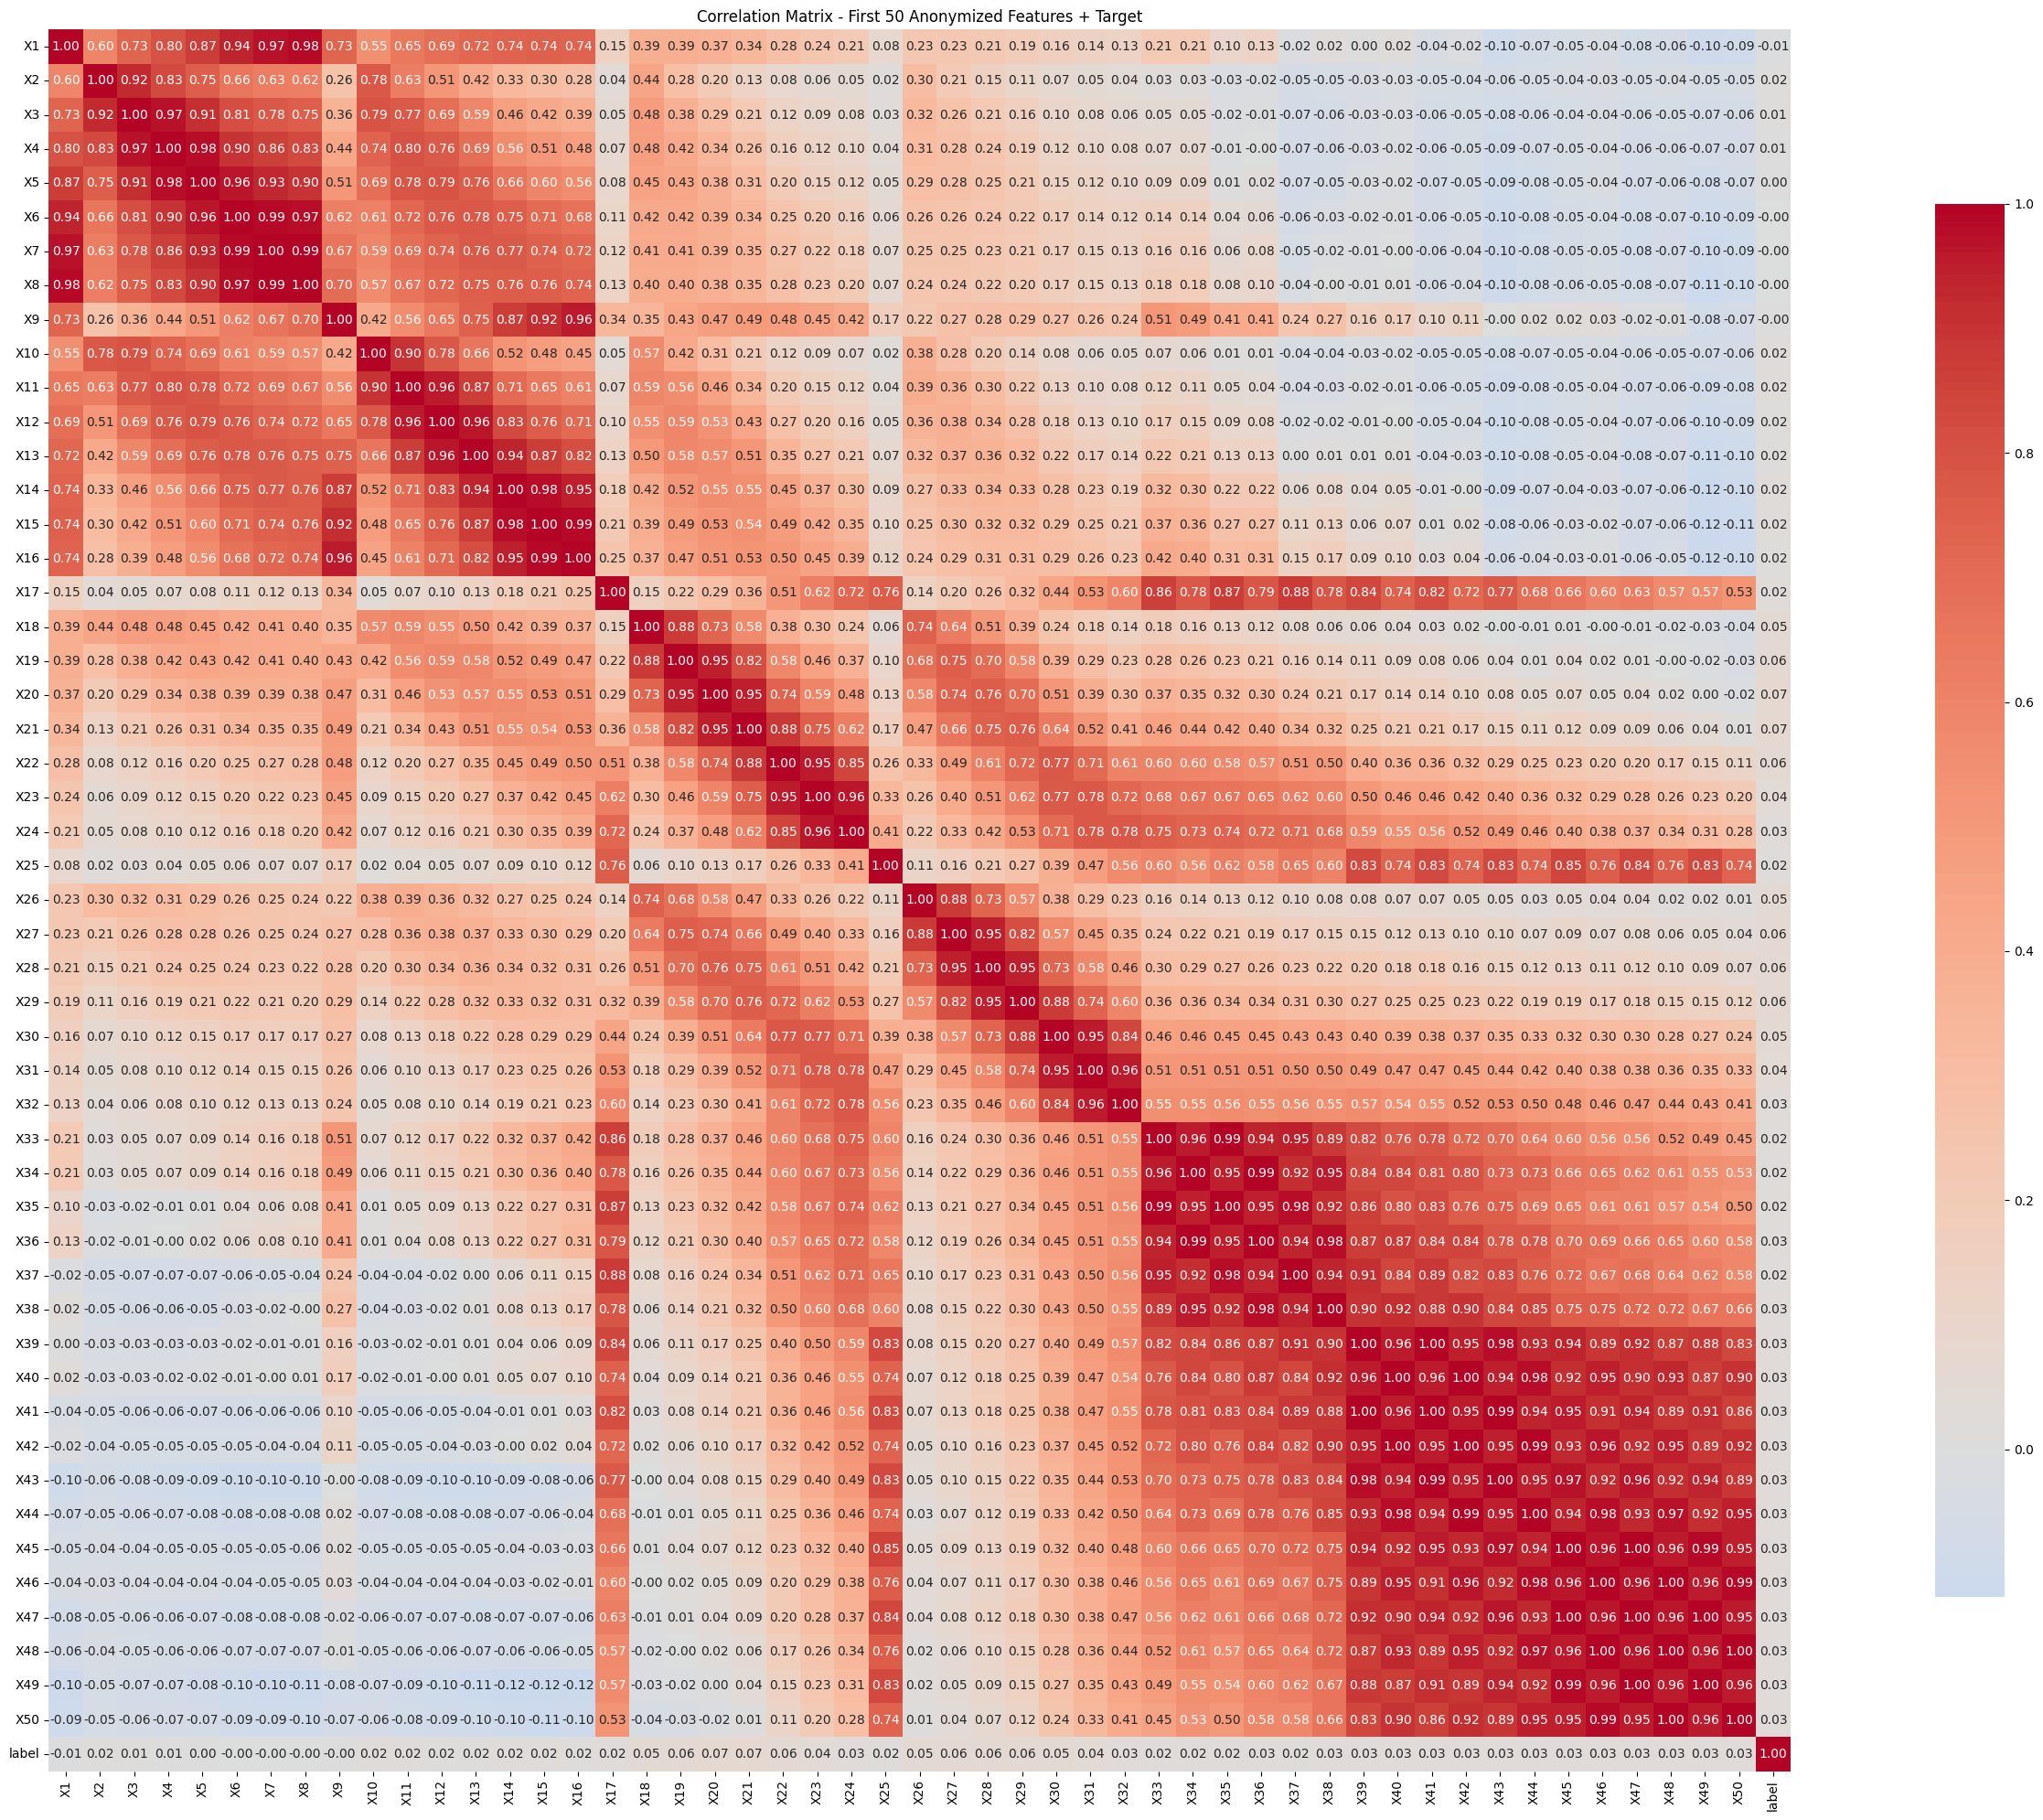

In [19]:
# heatmap correlation between features


subset_features = anonymized_features[:50]
correlation_matrix = train[subset_features + [target]].corr()

# Plot correlation heatmap
plt.figure(figsize=(32, 20))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            square=True, fmt='.2f',annot=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix - First 50 Anonymized Features + Target')
plt.tight_layout()
plt.show()

In [20]:
def find_high_correlations(corr_matrix, threshold=0.8):
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs += [{
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                }]
    return pd.DataFrame(high_corr_pairs)

high_corr_df = find_high_correlations(correlation_matrix, threshold=0.98)
print(f"High correlation pairs (|corr| > 0.98):")
print(high_corr_df.sort_values('correlation', key=abs, ascending=False).head(50))

# Correlation with target variable
target_correlations = train[anonymized_features + [target]].corr()[target].abs().sort_values(ascending=False)
print(f"\nTop 20 features most correlated with target:")
print(target_correlations.head(51)[1:])  # Exclude target itself

High correlation pairs (|corr| > 0.98):
   feature1 feature2  correlation
16      X46      X48     0.998509
14      X45      X47     0.998474
10      X40      X42     0.997352
8       X39      X41     0.997094
19      X48      X50     0.996034
18      X47      X49     0.996024
2        X7       X8     0.994787
6       X34      X36     0.993137
13      X42      X44     0.992733
12      X41      X43     0.992203
5       X33      X35     0.992038
1        X6       X7     0.990956
17      X46      X50     0.989819
15      X45      X49     0.989732
4       X15      X16     0.988683
0        X1       X8     0.982965
3       X14      X15     0.982270
11      X40      X44     0.981736
7       X36      X38     0.981475
9       X39      X43     0.980295

Top 20 features most correlated with target:
X21     0.069401
X20     0.067667
X28     0.064092
X863    0.064057
X29     0.062339
X19     0.062293
X27     0.062251
X22     0.057676
X858    0.057320
X219    0.056713
X860    0.056259
X531    0.056

### PCA分析，降维

Performing Incremental PCA...
Number of components needed for 90% variance: 23
Number of components needed for 95% variance: 36


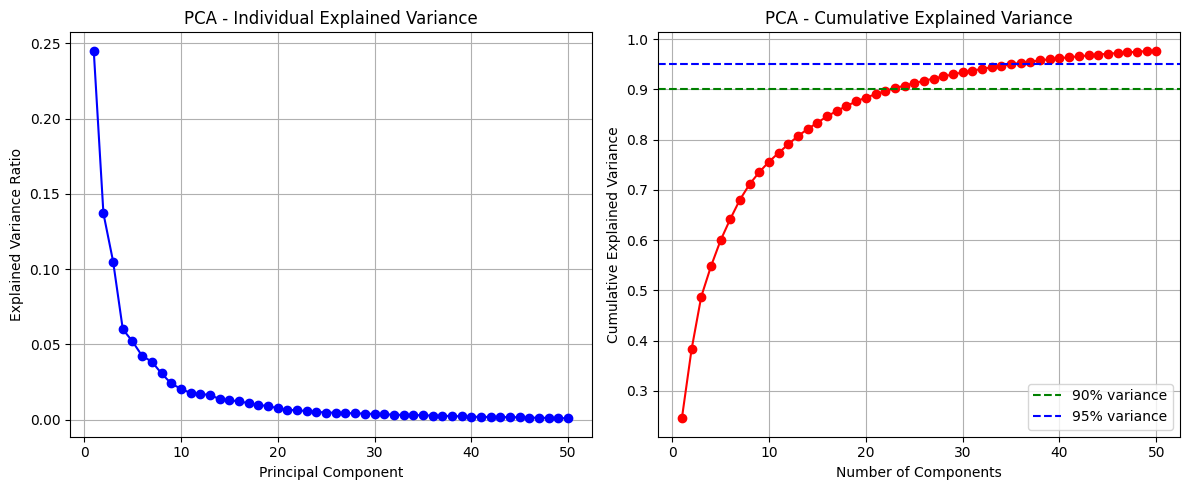

In [21]:
from sklearn.decomposition import IncrementalPCA


X_numeric = train[anonymized_features].select_dtypes(include=[np.number]).iloc[:, :200]

# 2. Fill missing values with column median
X_clean = X_numeric.fillna(X_numeric.median())

# 3. Downcast to float32 to save memory
X_clean = X_clean.astype(np.float32)

# 4. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# 5. Perform Incremental PCA
print("Performing Incremental PCA...")
ipca = IncrementalPCA(n_components=50, batch_size=200)
X_pca = ipca.fit_transform(X_scaled)

# 6. Explained variance analysis
explained_variance_ratio = ipca.explained_variance_ratio_
cumsum_variance = np.cumsum(explained_variance_ratio)
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1

print(f"Number of components needed for 90% variance: {n_components_90}")
print(f"Number of components needed for 95% variance: {n_components_95}")

# 7. Plot explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA - Individual Explained Variance')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 'ro-')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% variance')
plt.axhline(y=0.95, color='b', linestyle='--', label='95% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Performing t-SNE on sample data...


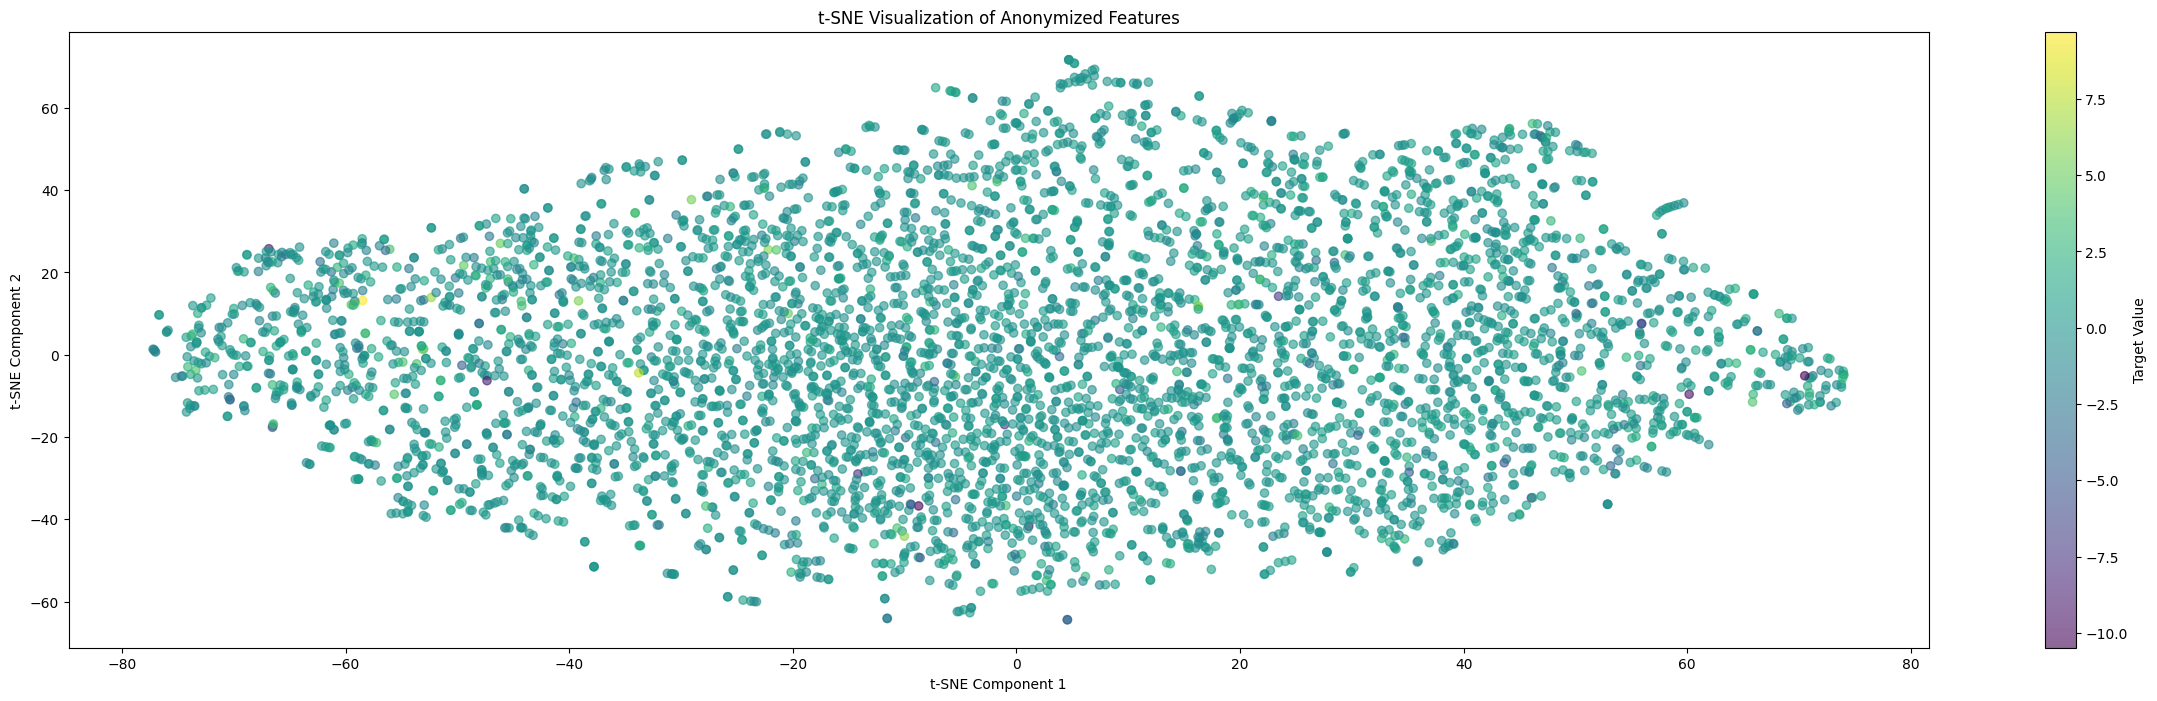

In [23]:
# t-SNE visualization (on a sample for computational efficiency)
print("Performing t-SNE on sample data...")
sample_size = min(5000, len(X_clean))
sample_indices = np.random.choice(len(X_clean), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

y = train[target]  # <-- Replace 'target' with your actual label column name
y_sample = y.iloc[sample_indices]

# Use PCA first to reduce dimensions before t-SNE
pca_pre = PCA(n_components=50)
X_pca_sample = pca_pre.fit_transform(X_sample)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca_sample)

plt.figure(figsize=(30, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, alpha=0.6, cmap='viridis')
plt.colorbar(scatter, label='Target Value')
plt.title('t-SNE Visualization of Anonymized Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

颜色区别不大，在二维图像上展示好像并没有明显的变化趋势与规律

特征选择

In [24]:
from sklearn.feature_selection import SelectKBest, f_regression


# 使用单变量的 f回归判断，其实就是 pearson排序

print("\n" + "="*50)
print("4. FEATURE SELECTION")
print("="*50)

# Univariate feature selection
print("Performing univariate feature selection...")
selector_univariate = SelectKBest(score_func=f_regression, k=100)
X_selected_univariate = selector_univariate.fit_transform(X_clean, y)

# Get feature scores
anonymized_features = X_clean.columns  # <-- Make sure this matches the full feature list
feature_scores = pd.DataFrame({
    'feature': anonymized_features,
    'score': selector_univariate.scores_
}).sort_values('score', ascending=False)

print("Top 20 features by univariate selection:")
print(feature_scores.head(20))


4. FEATURE SELECTION
Performing univariate feature selection...
Top 20 features by univariate selection:
    feature        score
20      X21  2545.205426
19      X20  2419.043468
27      X28  2169.164294
28      X29  2051.629187
18      X19  2048.614392
26      X27  2045.853913
21      X22  1755.193328
25      X26  1409.237624
29      X30  1296.648227
17      X18  1293.752245
180    X181  1274.197639
174    X175  1106.167447
22      X23  1065.115439
136    X137  1033.606563
94      X95   971.818857
197    X198   968.020727
30      X31   878.320597
130    X131   867.519286
88      X89   864.861363
196    X197   852.423746


In [25]:
from sklearn.ensemble import RandomForestRegressor

print("\nTraining Random Forest for feature importance (with speed-up)...")

rf = RandomForestRegressor(
    n_estimators=100,       # Reduce trees from 100 → 50 for faster training
    max_depth=10,          # Limit depth to prevent very deep trees
    max_features='sqrt',   # Use sqrt of features at each split (default)
    n_jobs=-1,             # Use all CPU cores
    random_state=42
)

rf.fit(X_clean, y)

feature_importance = pd.DataFrame({
    'feature': anonymized_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 features by Random Forest importance:")
print(feature_importance.head(20))


Training Random Forest for feature importance (with speed-up)...
Top 20 features by Random Forest importance:
    feature  importance
88      X89    0.023277
94      X95    0.023003
197    X198    0.022493
96      X97    0.017580
179    X180    0.016626
139    X140    0.015122
93      X94    0.015054
138    X139    0.014221
136    X137    0.014101
168    X169    0.013691
196    X197    0.013579
195    X196    0.013504
97      X98    0.013434
177    X178    0.013125
82      X83    0.012900
181    X182    0.012761
173    X174    0.012626
178    X179    0.012423
131    X132    0.012232
130    X131    0.011818


In [26]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.feature_selection import RFE

# lasso + rfe 相比于 f回归能考虑特征之间的相关性
# lasso alpha 0.01比较小，应该是设置越大，惩罚越大，回归系数压缩到 0的特征越多，但是如果没有，rfe也会迭代删除最弱的特征
# lasso 的系数排序不等于 rfe的排序。lasso有时对弱相关特征选择不稳定，rfe 更鲁棒。ref是反向过程，记录是最后被保留的排名，不是当前有多大的系数

print("\nPerforming Recursive Feature Elimination with Lasso...")

# Initialize Lasso with a small alpha (regularization strength) and enough iterations
lasso_cv = LassoCV(cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_clean, y)
print(f"Best alpha via CV: {lasso_cv.alpha_}")
lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=10000, random_state=42)

# RFE with step=50 (removes 50 features at a time) to speed up
rfe = RFE(estimator=lasso, n_features_to_select=100, step=50)

# Fit RFE on your data
rfe.fit(X_clean, y)

# Collect feature selection results
rfe_features = pd.DataFrame({
    'feature': anonymized_features,
    'selected': rfe.support_,
    'ranking': rfe.ranking_
}).sort_values('ranking')

selected_features_rfe = rfe_features[rfe_features['selected']]['feature'].tolist()
print(f"RFE selected {len(selected_features_rfe)} features")
print("Top 20 RFE selected features:")
print(rfe_features.head(20))


Performing Recursive Feature Elimination with Lasso...
RFE selected 100 features
Top 20 RFE selected features:
    feature  selected  ranking
25      X26      True        1
28      X29      True        1
20      X21      True        1
18      X19      True        1
43      X44      True        1
122    X123      True        1
121    X122      True        1
120    X121      True        1
119    X120      True        1
108    X109      True        1
110    X111      True        1
111    X112      True        1
105    X106      True        1
109    X110      True        1
113    X114      True        1
112    X113      True        1
124    X125      True        1
125    X126      True        1
126    X127      True        1
123    X124      True        1


Performing K-means clustering...


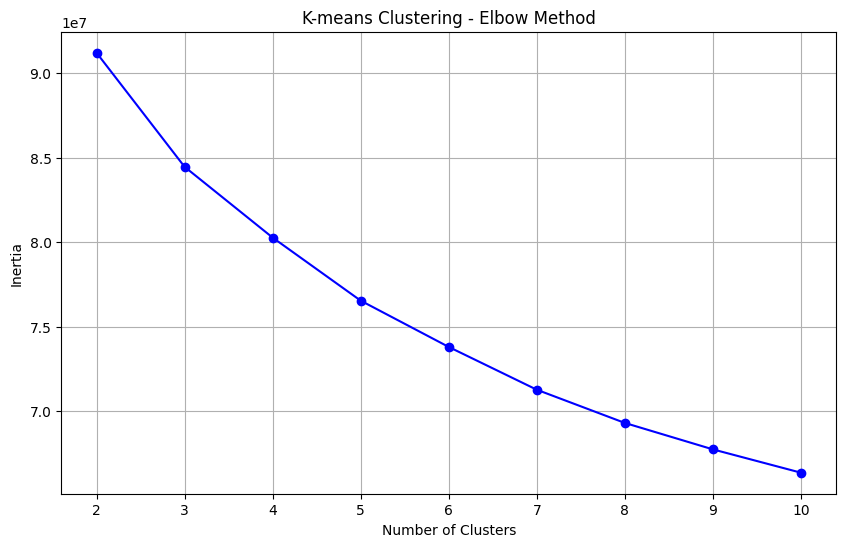

In [27]:
# 聚类分析
# 通过计算 inertia，簇内平方和惯性，选择最优的聚类数

# K-means clustering on PCA-reduced data
print("Performing K-means clustering...")
n_clusters_range = range(2, 11)
inertias = []

for k in n_clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca[:, :50])  # Use first 50 PCA components
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-means Clustering - Elbow Method')
plt.grid(True)
plt.show()



Cluster analysis with 5 clusters:
          count      mean       std
cluster                            
0        234484  0.021571  0.854230
1         35300  0.135612  1.677098
2         93941  0.054921  1.166162
3          7997  0.114777  1.016593
4        154165  0.019951  0.916305


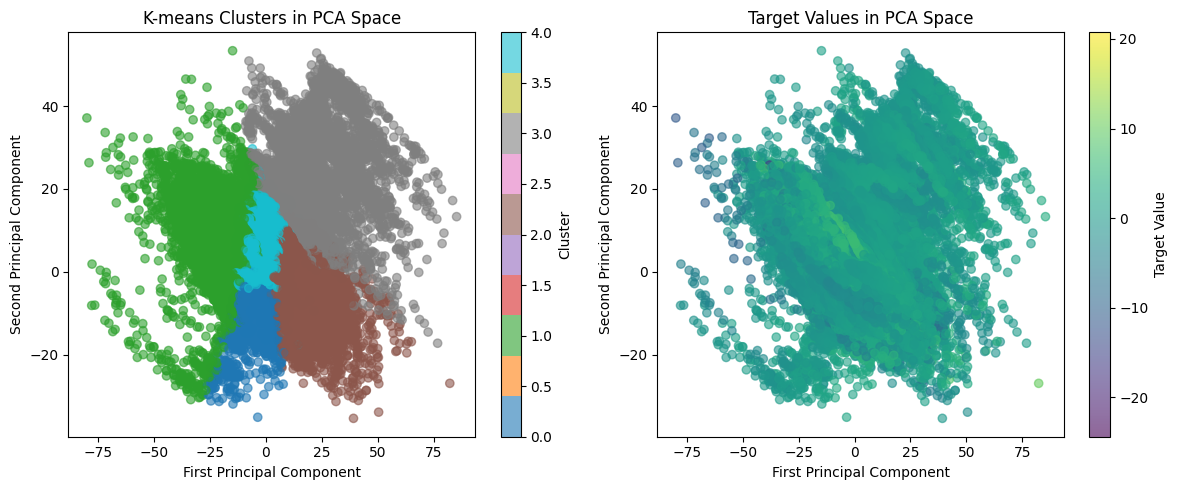

In [28]:
# Apply optimal clustering
optimal_k = 5  # You can adjust based on elbow curve
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_final.fit_predict(X_pca[:, :50])

# Analyze clusters
cluster_analysis = pd.DataFrame({
    'cluster': clusters,
    'target': y
})

print(f"\nCluster analysis with {optimal_k} clusters:")
cluster_stats = cluster_analysis.groupby('cluster')['target'].agg(['count', 'mean', 'std'])
print(cluster_stats)

# Visualize clusters using first 2 PCA components
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, alpha=0.6, cmap='tab10')
plt.colorbar(scatter, label='Cluster')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-means Clusters in PCA Space')

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.6, cmap='viridis')
plt.colorbar(scatter, label='Target Value')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Target Values in PCA Space')

plt.tight_layout()
plt.show()

In [29]:

print(f"1. Dataset contains {890} anonymized features")
print(f"2. {n_components_90} components explain 90% of variance, {n_components_95} explain 95%")
print(f"3. Top correlated feature with target: {target_correlations.index[1]} (corr: {target_correlations.iloc[1]:.4f})")
print(f"4. {len(high_corr_df)} feature pairs have high correlation (>0.7)")
print(f"5. Optimal number of clusters appears to be around {optimal_k}")

# Save important features for further analysis
important_features = {
    'top_univariate': feature_scores.head(50)['feature'].tolist(),
    'top_rf_importance': feature_importance.head(50)['feature'].tolist(),
    'rfe_selected': selected_features_rfe,
    'high_target_corr': target_correlations.head(50).index[1:].tolist()
}

common_features = set(important_features['top_univariate']) & \
                 set(important_features['top_rf_importance']) & \
                 set(important_features['rfe_selected'])
print(f"  Common Features selected by all 3 methods: {(common_features)}")

1. Dataset contains 890 anonymized features
2. 23 components explain 90% of variance, 36 explain 95%
3. Top correlated feature with target: X21 (corr: 0.0694)
4. 20 feature pairs have high correlation (>0.7)
5. Optimal number of clusters appears to be around 5
  Common Features selected by all 3 methods: {'X181', 'X137', 'X125', 'X139', 'X198', 'X196', 'X131', 'X173', 'X179', 'X163', 'X175', 'X169', 'X133', 'X197'}


In [12]:
train.iloc[:10, list(range(5)) + [-1]]

bid_qty  ask_qty  buy_qty  sell_qty   volume     label
timestamp                                                                  
2023-03-01 00:00:00   15.283    8.425  176.405    44.984  221.389  0.562539
2023-03-01 00:01:00   38.590    2.336  525.846   321.950  847.796  0.533686
2023-03-01 00:02:00    0.442   60.250  159.227   136.369  295.596  0.546505
2023-03-01 00:03:00    4.865   21.016  335.742   124.963  460.705  0.357703
2023-03-01 00:04:00   27.158    3.451   98.411    44.407  142.818  0.362452
2023-03-01 00:05:00   29.454    5.540  309.371    97.460  406.831  0.100448
2023-03-01 00:06:00    3.478   29.514  100.608   233.525  334.133  0.178679
2023-03-01 00:07:00   16.591    3.230   46.034   218.806  264.840  0.463684
2023-03-01 00:08:00    5.560   30.919   40.259    82.518  122.777  0.686066
2023-03-01 00:09:00   12.697   14.827  125.650    90.750  216.400  0.637539

bid，ask 表示情绪；buy，sell，volume 表示行为；label 表示未来的价格处理后的信号
1. 各特征之间的比值 ratio
2. 